In [1]:
# import libraries
from cil.optimisation.algorithms import LADMM, PDHG
from cil.optimisation.functions import KullbackLeibler, WeightedL2NormSquared, MixedL21Norm, BlockFunction, IndicatorBox, TotalVariation
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator
from cil.framework import ImageGeometry, AcquisitionGeometry
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.display import show2D
from cil.plugins.ccpi_regularisation.functions import FGP_TV 

import matplotlib.pyplot as plt
import os, sys
import numpy as np

import tomophantom
from tomophantom import TomoP2D

In [2]:
# Load a tomophantom image 
model = 12 # select a model number from the library
N = 256 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom2D_np = TomoP2D.Model(model, N, path_library2D)    
ig = ImageGeometry(voxel_num_x=N, voxel_num_y=N, voxel_size_x = 0.5, voxel_size_y = 0.5)

phantom2D = ig.allocate()
phantom2D.fill(phantom2D_np)

In [3]:
# Create Acquisition Geometry
detectors =  int(np.sqrt(2)*N)
angles = np.linspace(0, np.pi, 90, dtype=np.float32)

ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles,angle_unit="radian")\
                        .set_panel(detectors, pixel_size=0.5)

In [4]:
device = "gpu"

In [5]:
# Create Projection Operator
A = ProjectionOperator(ig, ag, device )

In [6]:
# Create projection data and corrupt with noise
np.random.seed(10)

data = A.direct(phantom2D)
noisy_data = ag.allocate()

eta = ag.allocate(5)
scale = 2
n1 = np.random.poisson( scale*(data.as_array() + eta.as_array()))/scale
noisy_data.fill(n1)

/opt/anaconda3/envs/cil21_ep/lib/python3.8/site-packages/cil/utilities/display.py:298: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels_new)


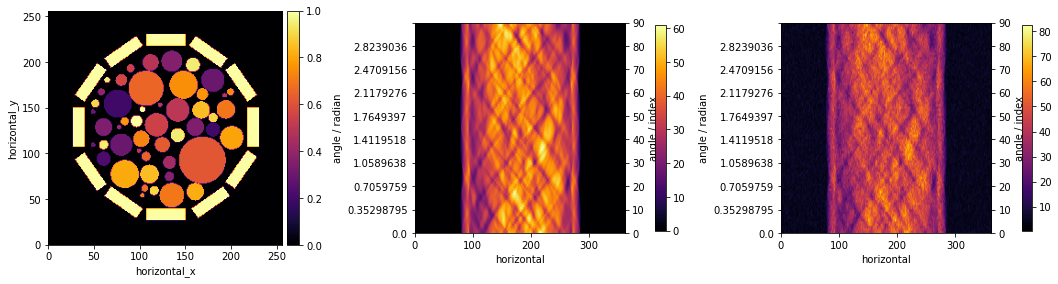

In [7]:
show2D([phantom2D, data, noisy_data], num_cols=3, cmap="inferno")

In [8]:
# Regularisation parameter
alpha = 0.5

In [9]:
# Setup and run ADMM  algorithm
Grad = GradientOperator(ig)
K = BlockOperator(Grad, A)
g = BlockFunction(alpha * MixedL21Norm(), KullbackLeibler(b=noisy_data,eta=eta))
f = IndicatorBox(lower=0.0)

normK = K.norm()
sigma = 1.
tau = sigma/normK**2

admm = LADMM(f=f, g=g, operator=K, sigma=sigma, tau=tau,
           max_iteration=1000, update_objective_interval=200)
admm.run(verbose=1)  

Initialised GradientOperator with C backend running with  20  threads
LADMM setting up
LADMM configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          9.61599e+05


/opt/anaconda3/envs/cil21_ep/lib/python3.8/site-packages/cil/framework/framework.py:2185: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      200       1000         0.016          1.95310e+04
      400       1000         0.016          1.49099e+04
      600       1000         0.017          1.31817e+04
      800       1000         0.017          1.22566e+04
     1000       1000         0.017          1.16954e+04
-------------------------------------------------------
     1000       1000         0.017          1.16954e+04
Stop criterion has been reached.



In [10]:
# Setup and run PDHG implicit algorithm
sigma = 1.
tau = 1./(sigma*normK**2)
pdhg = PDHG(f=g, g=f, operator=K, sigma=sigma, tau=tau,
           max_iteration=1000, update_objective_interval=200)
pdhg.run(verbose=2)

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       1000         0.000    9.61599e+05  -0.00000e+00    9.61599e+05
      200       1000         0.019    1.95779e+04  -1.35596e+04    3.31375e+04
      400       1000         0.019    1.49223e+04   7.97953e+02    1.41243e+04
      600       1000         0.018    1.31878e+04   4.11473e+03    9.07304e+03
      800       1000         0.018    1.22601e+04   5.81292e+03    6.44722e+03
     1000       1000         0.018    1.16977e+04   6.87455e+03    4.82311e+03
----------------------------------------------------------------------------
     1000       1000         0.018    1.16977e+04   6.87455e+03    4.82311e+03
Stop criterion has been reached.



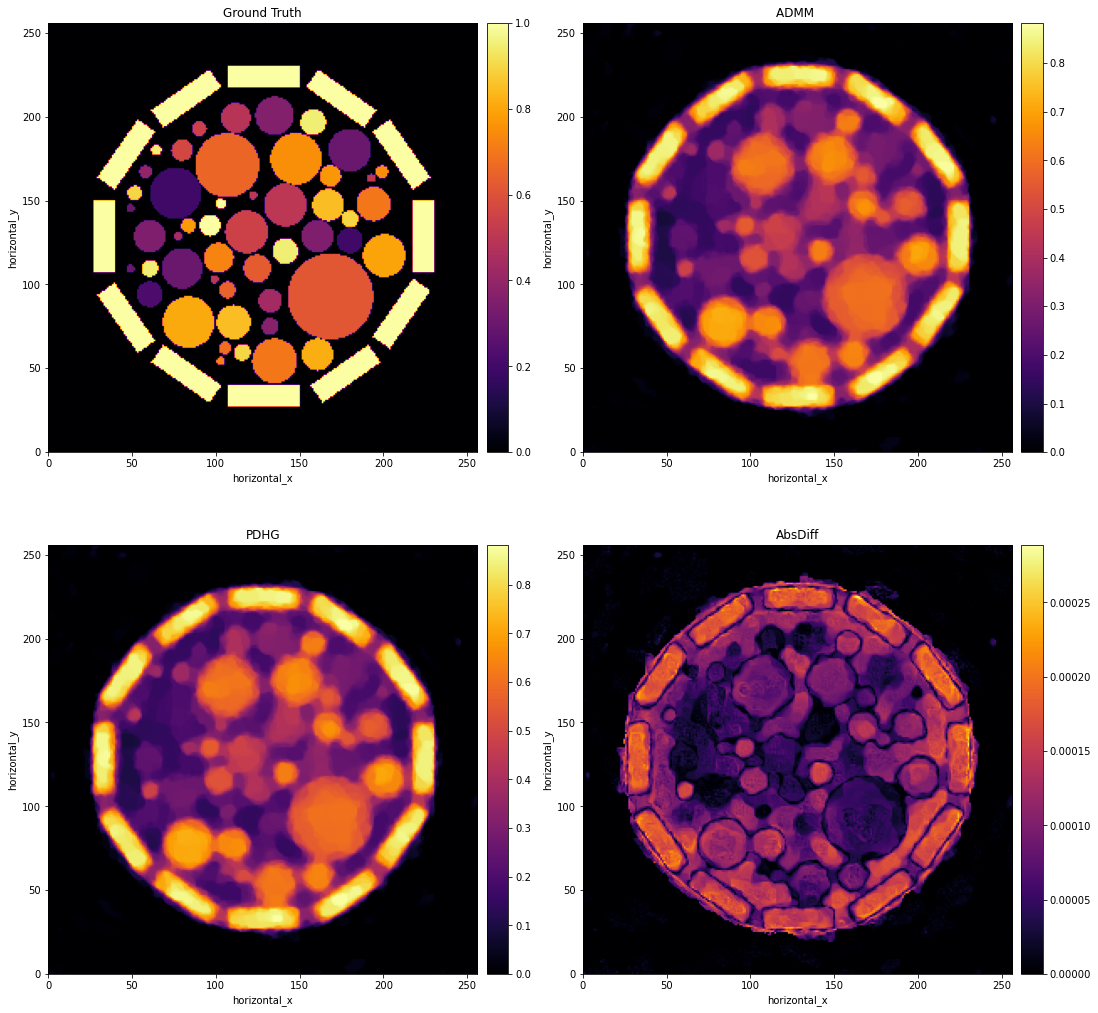

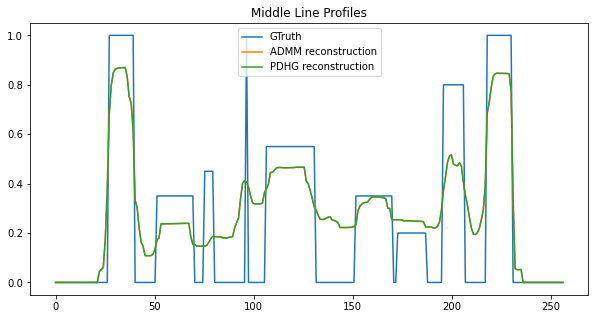

In [11]:
show2D([phantom2D, admm.solution, pdhg.solution, (admm.solution-pdhg.solution).abs()], 
       title=["Ground Truth", "ADMM ", "PDHG","AbsDiff"], cmap="inferno")

plt.figure(figsize=(10,5))            
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), phantom2D.as_array()[int(ig.shape[0]/2),:], label = 'GTruth')
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), admm.get_output().as_array()[int(ig.shape[0]/2),:], label = 'ADMM reconstruction')
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), pdhg.get_output().as_array()[int(ig.shape[0]/2),:], label = 'PDHG reconstruction')

plt.legend()
plt.title('Middle Line Profiles')
plt.show()